# Notebook Lecture 1: Introduction, Digital Control Systems
© 2025 ETH Zurich, Niclas Scheuer, Oscar von Freiherr, Anna Bodnar, Yunus Yazoglu; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

This interactive notebook covers the basics of discrete-time control and aliasing.

Authors:
- Niclas Scheuer; nscheuer@ethz.ch
- Oscar von Freiherr; ofreiherr@ethz.ch

## Import the packages

In [1]:
%pip install numpy matplotlib ipywidgets scipy

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ---------------------------------------- 0.1/12.9 MB 2.6 MB/s eta 0:00:06
     - -------------------------------------- 0.6/12.9 MB 7.4 MB/s eta 0:00:02
     --- ------------------------------------ 1.3/12.9 MB 10.0 MB/s eta 0:00:02
     ----- ---------------------------------- 1.7/12.9 MB 10.5 MB/s eta 0:00:02
     ----- ---------------------------------- 1.8/12.9 MB 8.3 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.9 MB 11.0 MB/s eta 0:00:01
     ---------- ----------------------------- 3.5/12.9 MB 10.7 MB/s eta 0:00:01
     ------------ --------------------------- 4.1/12.9 MB 11.4 MB/s eta 0:00:01
     -------------- ------------------------- 4.7/12.9 MB 11.6 MB/s eta 0:00:01
     ---------------- ----------------------- 5.3/12.9 MB 11.8 MB/s eta 0:00:01
     ------------------ --------------------- 5.9/12.9 MB 11.8 MB/s eta 0:00:01
     ------------------ --------------------- 6.1/1


[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets
from IPython.display import display
from matplotlib.axes import Axes
from scipy.optimize import curve_fit
from scipy.fftpack import fft, fftfreq
from scipy import signal
from scipy.integrate import solve_ivp
from typing import List

# Example 1: Zero-Order Hold

The zero-order hold is perhaps the simplest method to turn a _discrete-time_ (DT) signal into a _continuous-time_ (CT) signal. It does this by taking the value of the input at time $$t_0 = kT$$ and holding this output for the whole sampling period $$t \in [kT, (k+1)T)$$



In [ ]:
def zero_order_hold_plot(fs: int) -> None:
    """
    Plots a zero-order hold (ZOH) representation of a sampled sine wave.
    """
    T: float = 2  # Total time in seconds
    t_cont: np.ndarray = np.linspace(0, T, 1000)  # Continuous time axis
    signal_cont: np.ndarray = np.sin(2 * np.pi * 1 * t_cont)  # Continuous sine wave
    
    t_samples: np.ndarray = np.arange(0, T, 1 / fs)  # Discrete sample times
    signal_samples: np.ndarray = np.sin(2 * np.pi * 1 * t_samples)  # Sampled signal
    
    # Create ZOH signal by repeating each sample value until the next sample
    t_zoh: np.ndarray = np.repeat(t_samples, 2)
    signal_zoh: np.ndarray = np.repeat(signal_samples, 2)
    
    # Adjust last element to match the original timeline
    t_zoh = np.append(t_zoh, T)
    signal_zoh = np.append(signal_zoh, signal_zoh[-1])
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(t_cont, signal_cont, 'b', label='Original Signal')  # Continuous signal
    ax.step(t_zoh, signal_zoh, 'r', where='post', label='Zero-Order Hold')  # ZOH signal
    ax.scatter(t_samples, signal_samples, color='black', zorder=3, label='Samples')  # Sample points
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Zero-Order Hold (Sampling Frequency = {fs} Hz)')
    ax.legend()
    ax.grid(True)
    display(fig)
    plt.close(fig)

# Create slider for sampling frequency
fs_slider = widgets.IntSlider(min=1, max=30, step=1, value=5, description='Fs (Hz)', continuous_update=False)
interactive_plot = widgets.interactive_output(zero_order_hold_plot, {'fs': fs_slider})
display(fs_slider, interactive_plot)


# Example 2: Nyquist-Shannon Sampling Theorem

If we don't sample a signal often enough, we lose important details, making it hard to reconstruct the original signal.

## Sinuisoidal Signals and Sampling
Since any signal can be broken down into sine waves using the Fourier transform, we use a basic sinusoidal signal to explain the Nyquist-Shannon Sampling Theorem.

## Nyquist-Shannon Sampling Theorem
A sampled signal can be perfectly reconstructed only if the sampling rate is at least twice the highest frequency present in the signal.

$$
f_s \geq 2f_{max}
$$

where:
- $f_s$ is the **sampling frequency**
- $f_{max}$ is the **highest frequency component** in the signal





In [ ]:
def sinusoid(t: np.ndarray, f: float) -> np.ndarray:
    """
    Generates a sinusoidal signal with a given frequency.
    """
    return np.sin(2 * np.pi * f * t)

def fit_sinusoid(t_samples: np.ndarray, y_samples: np.ndarray, f_s: float) -> callable:
    """
    Fits a sinusoidal function to sampled points using the lowest frequency possible.
    """
    def model(t: np.ndarray, A: float, f_fit: float, phase: float) -> np.ndarray:
        return A * np.sin(2 * np.pi * f_fit * t + phase)
    
    # Compute frequency components using FFT and determine aliased frequency
    f_samples: np.ndarray = np.fft.fftfreq(len(t_samples), d=(t_samples[1] - t_samples[0]))
    f_alias: float = np.abs(f_samples[np.argmax(np.abs(np.fft.fft(y_samples)))])
    f_guess: float = f_alias if f_alias < f_s / 2 else f_s - f_alias
    
    # Fit the sinusoid to sampled data
    params, _ = curve_fit(model, t_samples, y_samples, p0=[1, f_guess, 0])
    return lambda t: model(t, *params)

def nyquist_plot(f_max: float, f_s: float) -> None:
    """
    Visualizes the Nyquist-Shannon sampling theorem by comparing an original signal, sampled points, and a reconstructed sinusoid.
    """
    T: float = 1  # Total duration (1 second)
    t_cont: np.ndarray = np.linspace(0, T, 1000)  # High-resolution continuous time
    y_cont: np.ndarray = sinusoid(t_cont, f_max)  # Original continuous signal

    # Sampled points
    t_samples: np.ndarray = np.arange(0, T, 1/f_s)  # Discrete sample times
    y_samples: np.ndarray = sinusoid(t_samples, f_max)  # Sampled values

    # Fit a sinusoid to the sampled data
    fitted_sinusoid = fit_sinusoid(t_samples, y_samples, f_s)
    y_reconstructed: np.ndarray = fitted_sinusoid(t_cont)  # Reconstructed signal

    # Plot results
    plt.figure(figsize=(8, 4))
    plt.plot(t_cont, y_cont, 'b', label='Original Signal')  # Continuous signal
    plt.scatter(t_samples, y_samples, color='red', zorder=3, label='Sampled Points')  # Sampled points
    plt.plot(t_cont, y_reconstructed, 'g--', label='Reconstructed Signal')  # Reconstructed sinusoid
    
    # Nyquist theorem verification
    nyquist_condition: bool = f_s >= 2 * f_max
    condition_text: str = "✓ Nyquist Theorem Fulfilled" if nyquist_condition else "✗ Undersampling (Aliasing Can Occur!)"
    
    plt.title(f'Nyquist-Shannon Sampling Theorem\n{condition_text}', fontsize=12, color='green' if nyquist_condition else 'red')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive sliders
f_max_slider = widgets.FloatSlider(min=1, max=10, step=0.5, value=3, description='f_max (Hz)')
f_s_slider = widgets.FloatSlider(min=2, max=20, step=0.5, value=6, description='f_s (Hz)')

# Display interactive plot
interactive_plot = widgets.interactive_output(nyquist_plot, {'f_max': f_max_slider, 'f_s': f_s_slider})
display(f_max_slider, f_s_slider, interactive_plot)


# Example 2B: Nyquist-Shannon Sampling Theorem
This example is similar to the above, except it uses a **linear combination** of sinusoidal signals. There is a risk of aliasing as soon as the sampling frequency $f_s$ drops below the highest frequency component $f_{max}$ of the linear combination.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.optimize import curve_fit
from scipy.fftpack import fft, fftfreq

# Global storage for the original signal
global_t_cont: np.ndarray = np.linspace(0, 1, 1000)  # High-resolution time
global_freq_options: np.ndarray = np.array([1, 2, 5, 10, 20])  # Available frequency components
global_num_components: int = 2  # Default number of harmonics
global_f_s: float = 20  # Default sampling frequency

def generate_signal(num_components: int) -> None:
    """
    Generates a multi-component sinusoidal signal using predefined frequency options.
    """
    global global_freqs, global_amps, global_phases, global_y_cont
    global_freqs = global_freq_options[:num_components]  # Selected frequencies
    global_amps = np.ones(len(global_freqs))  # Amplitudes set to 1
    global_phases = np.random.uniform(0, 2*np.pi, len(global_freqs))  # Random phases
    
    global_y_cont = sum(
        A * np.sin(2 * np.pi * f * global_t_cont + p)
        for A, f, p in zip(global_amps, global_freqs, global_phases)
    )

# Generate initial signal
generate_signal(global_num_components)

def fit_sinusoids(t_samples: np.ndarray, y_samples: np.ndarray, freqs: np.ndarray) -> callable:
    """
    Fits multiple sinusoids to sampled points using known frequency components.
    """
    def model(t: np.ndarray, *params) -> np.ndarray:
        A: np.ndarray = np.array(params[:len(freqs)])
        P: np.ndarray = np.array(params[len(freqs):])
        return sum(A[i] * np.sin(2 * np.pi * freqs[i] * t + P[i]) for i in range(len(freqs)))
    
    p0: list[float] = [1] * len(freqs) + [0] * len(freqs)  # Initial guess: Amplitudes = 1, Phases = 0
    params, _ = curve_fit(model, t_samples, y_samples, p0=p0)
    return lambda t: model(t, *params)

def nyquist_plot() -> None:
    """
    Visualizes Nyquist-Shannon sampling theorem with multi-component sinusoidal signals.
    """
    T: float = 1  # Total duration (1 second)
    num_samples: int = int(T * global_f_s)  # Number of samples based on sampling frequency
    t_samples: np.ndarray = np.linspace(0, T, num_samples, endpoint=False)
    y_samples: np.ndarray = sum(
        A * np.sin(2 * np.pi * f * t_samples + p)
        for A, f, p in zip(global_amps, global_freqs, global_phases)
    )

    # Reconstructed signal
    fitted_sinusoids = fit_sinusoids(t_samples, y_samples, global_freqs)
    y_reconstructed: np.ndarray = fitted_sinusoids(global_t_cont)

    # Nyquist Criterion Check
    max_freq: float = max(global_freqs)
    nyquist_condition: bool = global_f_s >= 2 * max_freq
    condition_text: str = "\n\n✓ Nyquist Theorem Fulfilled" if nyquist_condition else "\n\n✗ Undersampling (Aliasing Occurs!)"

    # Plot time domain representation
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.title(f'Nyquist-Shannon Sampling Theorem {condition_text}', fontsize=12, color='green' if nyquist_condition else 'red')
    plt.plot(global_t_cont, global_y_cont, 'b', label='Original Signal')
    plt.scatter(t_samples, y_samples, color='red', zorder=3, label='Sampled Points')
    plt.plot(global_t_cont, y_reconstructed, 'g--', label='Reconstructed Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    # Fourier Transform Analysis
    N: int = 4096  # Increased FFT resolution
    freqs_cont: np.ndarray = fftfreq(N, d=(global_t_cont[1] - global_t_cont[0]))
    spectrum_cont: np.ndarray = np.abs(fft(global_y_cont, n=N))
    spectrum_cont /= np.max(spectrum_cont)  # Normalize original spectrum
    
    N_samples: int = 4096  # Ensuring FFT resolution matches
    freqs_samples: np.ndarray = fftfreq(N_samples, d=(t_samples[1] - t_samples[0]))
    spectrum_samples: np.ndarray = np.abs(fft(y_samples, n=N_samples))
    spectrum_samples /= np.max(spectrum_samples)  # Normalize sampled spectrum
    
    # Plot frequency domain representation
    plt.subplot(2, 1, 2)
    plt.title("Magnitude plot")
    plt.plot(freqs_cont[:N//2], spectrum_cont[:N//2], 'b', label='Original Spectrum')
    plt.plot(freqs_samples[:N_samples//2], spectrum_samples[:N_samples//2], 'r--', label='Sampled Spectrum')
    plt.xlim(0, 40)  # Limit frequency axis to 40 Hz
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized Magnitude')
    plt.legend()
    plt.grid(True)

    # Annotate expected frequency peaks
    for f in global_freqs:
        plt.axvline(f, color='gray', linestyle='dashed', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# Interactive controls
num_components_slider = widgets.IntSlider(
    min=1, max=len(global_freq_options), step=1, value=global_num_components, description='Harmonics'
)
f_s_slider = widgets.FloatSlider(
    min=5, max=50, step=1, value=global_f_s, description='f_s (Hz)'
)

def update_plot(num_components: int, f_s: float) -> None:
    """
    Updates the signal and re-renders the Nyquist plot based on user input.
    """
    global global_f_s
    if num_components != len(global_freqs):
        generate_signal(num_components)
    global_f_s = f_s
    nyquist_plot()

interactive_plot = widgets.interactive_output(update_plot, {'num_components': num_components_slider, 'f_s': f_s_slider})
display(num_components_slider, f_s_slider, interactive_plot)


We can observe in the plot above that if we have higher harmonics aliasing can occur. If the sampling frequency is too low, we get undersampling. This means the observed frequencies (red dotted line in magnited plot) do not match with actual frequencies (blue line).

# Example 2C: Wagon Wheel Effect
The wagon wheel effect is an optical illusion caused by aliasing. The wagon wheel effect appears when filming moving objects for example the spoked wheels of wagon or the propeller of an airplane. If the sampling frequency of video is roughly as fast as the rotation of the wagon wheel, we can see clearly the movement of the wheel, e.g. the animations with $f_s=60Hz$ and $f_s = 30Hz$. But when the sampling frequency is too low, it looks like the wheel is turning backwards, because of aliasing, see animation with $f_s = 5Hz$


Each of the $N$ spokes are seperated by $\frac{2\pi}{N}$. Each spoke moves by $\omega T_s$ between frames. When looking at one spoke, in the next frame our eye assumes the closest spoke is the same as the one from the previous frame. This allows us to write a requirement for the wheel to turn into the wrong direction. 
$$\frac{2\pi}{N} (k+1) > \omega T_s > \frac{\pi}{N} + \frac{2\pi}{N} k \quad k \in \mathbb{N}$$
For the case below $f_s = 5Hz$, we can verify this: $\omega = \frac{\pi}{2} \frac{1}{s} $; $T_s = \frac{1}{5} s$
$$ \frac{2\pi}{12} >  \frac{\pi}{10} > \frac{\pi}{12} $$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider
from IPython.display import display, HTML

# Global variables with types
num_spokes: int = 12           # Number of spokes on the wheel
wheel_radius: float = 1.0      # Radius of the wheel
rotation_speed: float = 90.0   # Rotation speed in degrees per second
frame_rates: List[int] = [60, 30, 15, 5]  # Different sampling frequencies to demonstrate aliasing

def draw_wheel(ax: Axes, angle: float) -> None:
    """
    Draws a wheel with spokes rotated by the given angle.
    """
    ax.clear()
    ax.set_xlim(-wheel_radius - 0.2, wheel_radius + 0.2)
    ax.set_ylim(-wheel_radius - 0.2, wheel_radius + 0.2)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Draw the outer circle of the wheel
    circle = plt.Circle((0, 0), wheel_radius, color='black', fill=False, linewidth=2)
    ax.add_patch(circle)
    
    # Draw each spoke
    for i in range(num_spokes):
        theta: float = np.radians(i * (360 / num_spokes) + angle)
        x: float = wheel_radius * np.cos(theta)
        y: float = wheel_radius * np.sin(theta)
        ax.plot([0, x], [0, y], 'k', linewidth=2)

def animate(frame: int, ax: Axes, fs: int) -> None:
    """
    Animates the wheel by updating the rotation angle based on the frame and sampling frequency.
    """
    angle: float = -rotation_speed * frame * (1 / fs)  # Calculate rotation angle for the current frame
    draw_wheel(ax, angle)

def create_animation(fs: int) -> str:
    """
    Creates and returns the HTML animation of the wheel for the given sampling frequency.
    """
    fig, ax = plt.subplots()
    ani: animation.FuncAnimation = animation.FuncAnimation(
        fig, animate, frames=100, fargs=(ax, fs), interval=1000 / fs
    )
    
    plt.close(fig)  # Prevents the static image from appearing
    return ani.to_jshtml()

# Create animations and display them side by side
animations_html: str = ''.join(
    f'<div style="display:inline-block; margin:10px;">'
    f'<p style="text-align:center; font-weight:bold;">{fs} Hz</p>'
    f'{create_animation(fs)}'
    f'</div>'
    for fs in frame_rates
)

display(HTML(f'<div style="display:flex; justify-content:center;">{animations_html}</div>'))


# Example 3: Inverted Pendulum Control´
Take the case of an inverted pendulum. The aim is to balance this pendulum on its end by moving the base of the pendulum horizontally. Such an experimental setup can be seen below:

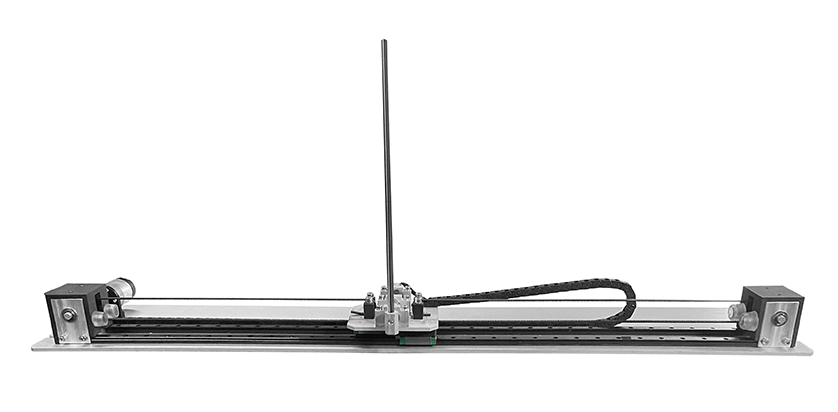

## Modeling
There are two major torques acting on the pendulum, namely the torque due to gravity and the torque due to the movement of the base:

$$\tau_g = -mg \cdot \frac{L}{2} \cdot \sin(\theta)$$

$$\tau_x = -m \ddot{x} \cdot \frac{L}{2} \cdot \cos(\theta)$$

Adding up all torques and rearranging:

$$I \ddot{\theta} = \tau_g + \tau_x$$

$$\frac{1}{3}L^2 \ddot{\theta} + \frac{L}{2} \ddot{x} \cos(\theta) + \frac{gL}{2} \sin(\theta) = 0$$

## Linearization
Using small-angle approximations:
- $\sin(\theta) \approx \theta$
- $\cos(\theta) \approx 1$

$$\ddot{\theta} + \frac{3}{2L}\ddot{x} + \frac{3g}{2L}\theta = 0$$

$$ G(s) = - \frac{\frac{3}{2L}s^2}{s^2 + \frac{3g}{2L}} $$

## Continuous Time Approach
Using knowledge from Control Systems I, this problem can be fully defined and solved in continuous time.

$$ PID(s) = K_p + \frac{K_i}{s} + K_d s $$

However, this approach will not work digitally in real life, such as when using a microcontroller, which implements control in discrete time. 

## Discrete Time Approach
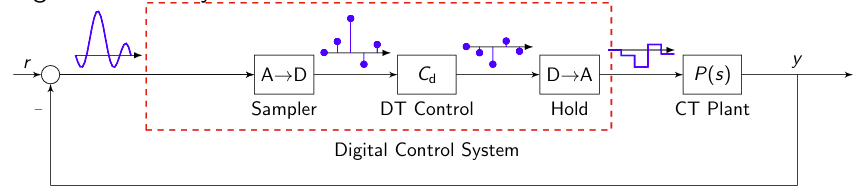

In the case of discrete-time control, we must first convert the physical continuous time data into discrete time data, implement the control scheme, and turn it back into continuous data (such as via a motor).

The below example demonstrates just that using the following steps, which may be visualized on the plot: 
- Filtering a noisy continuous time signal
- Sampling a continuous time signal
- Implemented PID control in discrete time
- Using zero-order hold for actuation commands

Investigate the effect of each step one after the one, i.e. left to right.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from scipy import signal
from scipy.integrate import solve_ivp
from typing import Tuple, Union, List

# ---------------------------
# Helper functions
# ---------------------------
def sinusoidal_signal(t: Union[float, np.ndarray], amplitude: float, frequency: float) -> Union[float, np.ndarray]:
    """Generate a sinusoidal signal with a given amplitude and frequency."""
    return amplitude * np.sin(2 * np.pi * frequency * t)

def apply_anti_aliasing_filter(input_signal: np.ndarray, cutoff_frequency: float, sampling_rate: float = 1000) -> np.ndarray:
    """Apply a low-pass Butterworth anti-aliasing filter to the input signal."""
    nyquist: float = 0.5 * sampling_rate
    normal_cutoff: float = cutoff_frequency / nyquist
    b, a = signal.butter(1, normal_cutoff, btype='low', analog=False)
    filtered_signal: np.ndarray = signal.filtfilt(b, a, input_signal)
    return filtered_signal

def inverted_pendulum_state_space(m: float, L: float, g: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Convert the inverted pendulum transfer function into a continuous state-space model."""
    num: List[float] = [0, 0, -3/(2*L)]
    den: List[float] = [1, 0, (3*g)/(2*L)]
    A, B, C, D = signal.tf2ss(num, den)
    return A, B, C, D

# ---------------------------
# Discrete-Time Simulation with ZOH
# ---------------------------
def simulate_and_plot_closed_loop(
    show_reference_signal: bool,
    reference_signal_amplitude: float,
    reference_signal_frequency: float,
    show_error_signal: bool,
    noise_amplitude: float,
    noise_frequency: float, 
    activate_noise: bool,
    show_noisy_reference: bool,
    activate_aaf: bool,
    cutoff_frequency: float,
    show_reference_aaf: bool,
    sampling_frequency: float, 
    pid_p: float,
    pid_i: float,
    pid_d: float, 
    show_controller_output: bool,
    show_zero_order_hold: bool,
    show_sampled_points: bool,
    show_pendulum_position: bool
) -> None:
    """Simulate a discrete-time PID controller with ZOH on inverted pendulum dynamics and plot the results."""
    with output:
        output.clear_output(wait=True)
        T_total: float = 20.0               # Total simulation time (s)
        dt_sample: float = 1.0 / sampling_frequency  # Sampling time interval (s)
        t_samples: np.ndarray = np.arange(0, T_total + dt_sample, dt_sample)
        
        # Continuous time grid for plotting continuous signals.
        t_cont: np.ndarray = np.linspace(0, T_total, 1000)
        # Always compute the reference signal (in degrees) regardless of the visual checkbox.
        r_cont: Union[float, np.ndarray] = sinusoidal_signal(t_cont, reference_signal_amplitude, reference_signal_frequency)
            
        if activate_noise:
            noise_cont: np.ndarray = sinusoidal_signal(t_cont, noise_amplitude, noise_frequency)
            # If AAF is active, precompute the filtered noise on the continuous grid.
            noise_filt_cont: np.ndarray = apply_anti_aliasing_filter(noise_cont, cutoff_frequency, sampling_rate=1000) \
                                          if activate_aaf else noise_cont
        else:
            noise_cont = np.zeros_like(t_cont)
            noise_filt_cont = noise_cont

        # Initialize discrete PID controller state variables.
        integral: float = 0.0
        e_prev: float = 0.0
        
        # Lists for simulation results.
        t_total_sim: List[float] = []       # Continuous simulation time.
        x_total_sim: List[List[float]] = []   # Plant states: [theta (rad), omega].
        u_total_sim: List[float] = []         # Control signal (held constant over each interval, in radians).
        discrete_times: List[float] = []      # Sampling instants.
        discrete_u: List[float] = []          # Discrete PID outputs (radians).
        
        # Lists for discrete error (for Err+Noise with AAF markers).
        discrete_r_list: List[float] = []       # Reference (degrees) at each sample.
        discrete_theta_list: List[float] = []   # Plant output (degrees) at each sample.
        discrete_error_AAF_list: List[float] = []  # (Reference + noise_effect) - plant angle (in degrees)
        
        # Plant parameters.
        m: float = 1
        L: float = 1
        g: float = 9.81
        A, B, C, D = inverted_pendulum_state_space(m, L, g)
        # Initial plant state: 10° offset (converted to radians) and zero angular rate.
        x_current: np.ndarray = np.array([10 * np.pi / 180, 0])
        
        # Simulation loop over each sampling interval.
        for k in range(len(t_samples) - 1):
            t_k: float = t_samples[k]
            t_next: float = t_samples[k + 1]
            
            # Always sample the reference (in degrees).
            r_sample: float = sinusoidal_signal(t_k, reference_signal_amplitude, reference_signal_frequency)  # in degrees
            discrete_r_list.append(r_sample)
            
            # Determine the noise sample.
            if activate_noise:
                # For the controller, always use noise if activated.
                raw_noise: float = sinusoidal_signal(t_k, noise_amplitude, noise_frequency)
                # For the AAF version, if filtering is activated, use the filtered noise.
                filtered_noise: float = np.interp(t_k, t_cont, noise_filt_cont) if activate_aaf else raw_noise
                # Effective noise used in the controller: if AAF is active, use filtered noise.
                effective_noise: float = filtered_noise if activate_aaf else raw_noise
            else:
                raw_noise = 0.0
                filtered_noise = 0.0
                effective_noise = 0.0
            
            # The controller "sees" a setpoint.
            # Now the controller uses the effective noise (which is filtered if AAF is on).
            setpoint_deg: float = r_sample + effective_noise
            
            # Sample the plant output (theta in radians) at t_k.
            theta_sample: float = x_current[0]
            discrete_theta_list.append(np.rad2deg(theta_sample))
            
            # Compute error (in radians) for PID: (setpoint converted to radians) minus plant angle.
            error: float = np.deg2rad(setpoint_deg) - theta_sample
            
            # Compute discrete PID.
            integral += error * dt_sample
            derivative: float = 0.0 if k == 0 else (error - e_prev) / dt_sample
            u_discrete: float = pid_p * error + pid_i * integral + pid_d * derivative  # [radians]
            e_prev = error
            
            # Store the discrete control sample.
            discrete_times.append(t_k)
            discrete_u.append(u_discrete)
            
            # Also compute the discrete error for "Err+Noise with AAF" markers.
            if show_reference_aaf:
                discrete_error_AAF: float = (r_sample + filtered_noise) - np.rad2deg(theta_sample)
                discrete_error_AAF_list.append(discrete_error_AAF)
            
            # Simulate the continuous plant over this sample period with u_discrete held constant.
            sol = solve_ivp(lambda t, x: A @ x + B.flatten() * u_discrete, 
                            [t_k, t_next], x_current, t_eval=np.linspace(t_k, t_next, 10))
            if k == 0:
                t_total_sim.extend(sol.t.tolist())
                x_total_sim.extend(sol.y.T.tolist())
                u_total_sim.extend([u_discrete] * len(sol.t))
            else:
                t_total_sim.extend(sol.t[1:].tolist())
                x_total_sim.extend(sol.y.T[1:].tolist())
                u_total_sim.extend([u_discrete] * (len(sol.t) - 1))
            x_current = sol.y[:, -1]
        
        # Convert simulation results to arrays.
        t_total_sim_arr: np.ndarray = np.array(t_total_sim)
        x_total_sim_arr: np.ndarray = np.array(x_total_sim)
        u_total_sim_arr: np.ndarray = np.array(u_total_sim)
        discrete_times_arr: np.ndarray = np.array(discrete_times)
        
        # Convert plant angle from radians to degrees.
        theta_deg: np.ndarray = np.rad2deg(x_total_sim_arr[:, 0])
        # Convert control signal from radians to degrees.
        u_deg: np.ndarray = np.rad2deg(u_total_sim_arr)       # Continuous (ZOH) control signal.
        discrete_u_deg: np.ndarray = np.rad2deg(np.array(discrete_u))  # Discrete controller output.
        
        # --- Compute Continuous Error Signals ---
        r_sim: np.ndarray = sinusoidal_signal(t_total_sim_arr, reference_signal_amplitude, reference_signal_frequency)
        error_plain: np.ndarray = r_sim - theta_deg
        noise_sim: np.ndarray = sinusoidal_signal(t_total_sim_arr, noise_amplitude, noise_frequency) if activate_noise else np.zeros_like(t_total_sim_arr)
        error_noise: np.ndarray = (r_sim + noise_sim) - theta_deg
        noise_filt_sim: np.ndarray = apply_anti_aliasing_filter(noise_sim, cutoff_frequency, sampling_rate=1000) if activate_aaf else noise_sim
        error_aaf: np.ndarray = (r_sim + noise_filt_sim) - theta_deg
        
        # --- Plotting ---
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if show_pendulum_position:
            ax.plot(t_total_sim_arr, theta_deg, label="Pendulum Angle (°)", color='magenta')
        
        if show_reference_signal:
            ax.plot(t_cont, r_cont, label="Reference Signal (°)", color='blue', linestyle='--')
        
        if show_error_signal:
            ax.plot(t_total_sim_arr, error_plain, label="Error (Ref - Pendulum)", color='red', linestyle='-.')
        if show_noisy_reference:
            ax.plot(t_total_sim_arr, error_noise, label="Error with Noise", color='brown', linestyle='--')
        if show_reference_aaf:
            ax.plot(t_total_sim_arr, error_aaf, label="Error with AAF", color='green', linestyle=':')
        
        if show_controller_output:
            ax.step(t_total_sim_arr, u_deg, 'o', where='post', label="Discrete PID Output (°)", color='black', markersize=1.5)
        
        if show_sampled_points and show_reference_aaf and discrete_error_AAF_list:
            ax.plot(discrete_times_arr, discrete_error_AAF_list, 'o', label="Sampled Err+Noise with AAF", color='orange', markersize=1.5)
        
        if show_zero_order_hold:
            ax.step(t_total_sim_arr, u_deg, where='post', label="Zero-Order Hold (°)", color='purple', alpha=0.5)
        
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude (°)")
        ax.set_title("Discrete-Time PID Controller with ZOH on Pendulum Dynamics")
        ax.set_ylim(-20, 20)
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

# ---------------------------
# Interactive Widgets Setup
# ---------------------------
output: widgets.Output = widgets.Output()

# Reference signal section.
reference_signal_amplitude_slider: widgets.FloatSlider = widgets.FloatSlider(value=1.0, min=0, max=2, step=0.1, description='Ref Amp (°):')
reference_signal_frequency_slider: widgets.FloatSlider = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01, description='Ref Freq (Hz):')
show_reference_signal_checkbox: widgets.Checkbox = widgets.Checkbox(value=True, description="Show Reference Signal")

# Error section – plots error = (Reference - Pendulum).
show_error_signal_checkbox: widgets.Checkbox = widgets.Checkbox(value=False, description="Show Error")

# Noise section.
activate_noise_checkbox: widgets.Checkbox = widgets.Checkbox(value=False, description="Activate Noise")
noise_amplitude_slider: widgets.FloatSlider = widgets.FloatSlider(value=1.0, min=0, max=2, step=0.1, description='Noise Amp (°):')
noise_frequency_slider: widgets.FloatSlider = widgets.FloatSlider(value=1, min=0.5, max=2, step=0.1, description='Noise Freq (Hz):')
# Renamed: Show Reference with Noise -> Show Error with Noise.
show_noisy_reference_checkbox: widgets.Checkbox = widgets.Checkbox(value=False, description="Show Error with Noise")

# AAF section.
activate_aaf_checkbox: widgets.Checkbox = widgets.Checkbox(value=False, description="Activate AAF")
cutoff_frequency_slider: widgets.FloatSlider = widgets.FloatSlider(value=20.0, min=0.1, max=40, step=0.1, description='Cutoff (Hz):')
# Renamed: Show Ref+Noise with AAF -> Show Err+Noise with AAF.
show_reference_aaf_checkbox: widgets.Checkbox = widgets.Checkbox(value=False, description="Show Err+Noise with AAF")

# Sampling section.
sampling_frequency_slider: widgets.FloatSlider = widgets.FloatSlider(value=5, min=1, max=20, step=1, description='Sampling Freq (Hz):')
show_sampled_points_checkbox: widgets.Checkbox = widgets.Checkbox(value=False, description="Show Sampled Points")

# PID section.
pid_p_slider: widgets.FloatSlider = widgets.FloatSlider(value=1.0, min=0, max=10, step=0.1, description='P Gain:')
pid_i_slider: widgets.FloatSlider = widgets.FloatSlider(value=0.0, min=0, max=10, step=0.1, description='I Gain:')
pid_d_slider: widgets.FloatSlider = widgets.FloatSlider(value=0.0, min=0, max=5, step=0.1, description='D Gain:')
show_controller_output_checkbox: widgets.Checkbox = widgets.Checkbox(value=False, description="Show Controller Output")

# New ZOH section (after PID).
show_zero_order_hold_checkbox: widgets.Checkbox = widgets.Checkbox(value=False, description="Show Zero-Order Hold")

# Pendulum position section.
show_pendulum_position_checkbox: widgets.Checkbox = widgets.Checkbox(value=False, description="Show Pendulum Position")

# Assemble interactive output.
widgets.interactive_output(simulate_and_plot_closed_loop, {
    'show_reference_signal': show_reference_signal_checkbox,
    'reference_signal_amplitude': reference_signal_amplitude_slider,
    'reference_signal_frequency': reference_signal_frequency_slider,
    'show_error_signal': show_error_signal_checkbox,
    'noise_amplitude': noise_amplitude_slider,
    'noise_frequency': noise_frequency_slider,
    'activate_noise': activate_noise_checkbox,
    'show_noisy_reference': show_noisy_reference_checkbox,
    'activate_aaf': activate_aaf_checkbox,
    'cutoff_frequency': cutoff_frequency_slider,
    'show_reference_aaf': show_reference_aaf_checkbox,
    'sampling_frequency': sampling_frequency_slider,
    'pid_p': pid_p_slider,
    'pid_i': pid_i_slider,
    'pid_d': pid_d_slider,
    'show_controller_output': show_controller_output_checkbox,
    'show_zero_order_hold': show_zero_order_hold_checkbox,
    'show_sampled_points': show_sampled_points_checkbox,
    'show_pendulum_position': show_pendulum_position_checkbox
})

# Layout the control sections.
reference_section: widgets.VBox = widgets.VBox([show_reference_signal_checkbox, reference_signal_amplitude_slider, reference_signal_frequency_slider])
error_section: widgets.VBox = widgets.VBox([show_error_signal_checkbox])
noise_section: widgets.VBox = widgets.VBox([activate_noise_checkbox, noise_amplitude_slider, noise_frequency_slider, show_noisy_reference_checkbox])
aaf_section: widgets.VBox = widgets.VBox([activate_aaf_checkbox, cutoff_frequency_slider, show_reference_aaf_checkbox])
sampling_section: widgets.VBox = widgets.VBox([sampling_frequency_slider, show_sampled_points_checkbox])
pid_section: widgets.VBox = widgets.VBox([pid_p_slider, pid_i_slider, pid_d_slider, show_controller_output_checkbox])
zoh_section: widgets.VBox = widgets.VBox([show_zero_order_hold_checkbox])
pendulum_section: widgets.VBox = widgets.VBox([show_pendulum_position_checkbox])

control_layout: widgets.HBox = widgets.HBox([reference_section, error_section, noise_section, aaf_section, sampling_section, pid_section, zoh_section, pendulum_section])
display(widgets.HBox([control_layout]), output)
